# Automated fitting of SPEIS data from any MPT file acquired _via_ EC-lab

Load the given file in the current directory, exctract relevant parameters stated in the header.

In [1]:
%load_ext jupyternotify
from impedance import preprocessing
import speis_data as sd
filename = 'Hem1_EIS_dark'
# Load data from the BioLabs MPT file
frequencies, Z = preprocessing.readBioLogic("./" + filename + ".mpt")
# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
pot_start, pot_step, potstepnumber = sd.read_mpt_parameters("./" + filename + ".mpt")

<IPython.core.display.Javascript object>

Initialize all implemented circuit models

In [2]:
from impedance.models.circuits import CustomCircuit

#Load Circuit with one parallel RC element
oneRC_string = 'R0-p(R1,C1)'
initial_guess_oneRC = [30, 1E+3, 1E-5]
bounds_oneRC = [[20, 1E+2, 1E-9], [50, 1E+7, 1E-2]]

oneRC = CustomCircuit(oneRC_string, initial_guess=initial_guess_oneRC)

#Load Circuit with one parallel RCPE element
oneRCPE_string = 'R0-p(R1,CPE1)'
parameters1rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P"]
initial_guess_oneRCPE = [30, 1E+3, 1E-5, 1]
bounds_oneRCPE = [[20, 1E+2, 1E-9, 0.8], [50, 1E+7, 1E-2, 1]]

oneRCPE = CustomCircuit(oneRCPE_string, initial_guess=initial_guess_oneRCPE)

#Load Circuit with two parallel RCPE elements
twoRCPE_string = 'R0-p(R1,CPE1)-p(R2,CPE2)'
parameters2rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P", "R_2", "CPE_2-T", "CPE_2-P"]
initial_guess_twoRCPE = [30, 1E+4, 1E-4, 1, 1E+2, 1E-6, 1]
bounds_twoRCPE = [[20, 1E+1, 1E-9, 0.8, 1E+0, 1E-9, 0.4], [50, 1E+7, 1E-2, 1, 1E+6, 1E-2, 1]]

twoRCPE = CustomCircuit(twoRCPE_string, initial_guess=initial_guess_twoRCPE)

## Measurement parameters

In [3]:
# Ask for the potential start and steps of the potential measurement
print("What was the pH of the solution?")
pot_pH = float(input())

What was the pH of the solution?
13


In [4]:
# split dataset into individual measurements separated by the initial measurement frequeny frequencies[0]
import numpy as np
frequencies = np.array_split(frequencies, potstepnumber)
Z = np.array_split(Z, potstepnumber)

# generate list with potentials vs. Ag/AgCl for each measurement
potentials_Ag = [(x)*pot_step+pot_start for x in range(potstepnumber)]
potentials_RHE = [x+197+59*pot_pH for x in potentials_Ag]

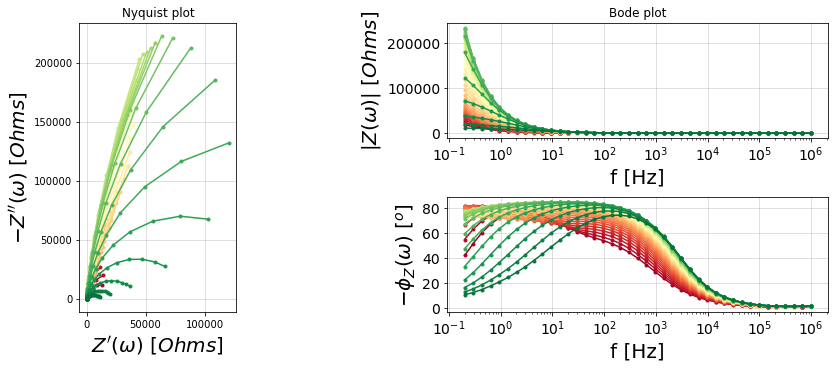

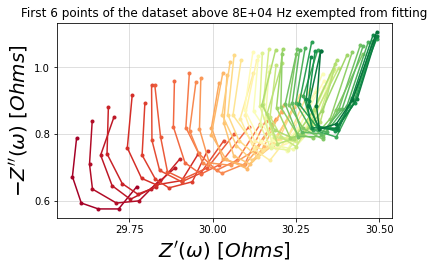

In [5]:
# Get an overview over the whole dataset
# %matplotlib notebook
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist
import speis_plot as sp

sp.plot_speis_overview(frequencies, Z)
plt.ion()
plt.show()

# Number of points to investigate based on frequency range
highest_freq = 8E+4
lowest_freq = 1E+1
cutoff_start, cutoff_end = sd.get_boundaries(highest_freq, lowest_freq*0.9, frequencies)

# Plot subrange
fig, ax = plt.subplots()
# plot_nyquist(ax, Z[:5][:cutoff_start], fmt='o')
sp.plot_speis_nyquist(ax, Z, cutoff=cutoff_start)
# for i in range(cutoff_start):
#     ax.annotate(i, (Z[0][i].real, -Z[0][i].imag))
plt.title("First " + str(cutoff_start) + " points of the dataset above "+ '{:.0E}'.format(highest_freq) + " Hz exempted from fitting")
plt.show()

## Selection of cycles to analyze

In [6]:
print("There are " + str(potstepnumber) + " cycles in total.")
print("With which cycle number do you want to start your analysis?")
cycle_start = int(input())-1
print("With which cycle number do you want to end your analysis?")
cycle_end = int(input())-1

There are 41 cycles in total.
With which cycle number do you want to start your analysis?
1
With which cycle number do you want to end your analysis?
41


## Selection of fitting model and fitting procedure

In [7]:
print("Which model do you want to use? (1RC, 1RCPE or 2RCPE)")
model = input()

if model == "1RC":
    results = [initial_guess_oneRC]
    model_circuit_bounds = bounds_oneRC
    model_circuit = oneRC
elif model == "1RCPE":
    results = [initial_guess_oneRCPE]
    model_circuit = oneRCPE
    model_circuit_bounds = bounds_oneRCPE
elif model == "2RCPE":
    results = [initial_guess_twoRCPE]
    model_circuit = twoRCPE
    model_circuit_bounds = bounds_twoRCPE
else:
    print("Eingabe ungültig")

Which model do you want to use? (1RC, 1RCPE or 2RCPE)
1RCPE


<IPython.core.display.Javascript object>

Result of Cycle 0 at 564.0 mV vs. RHE:


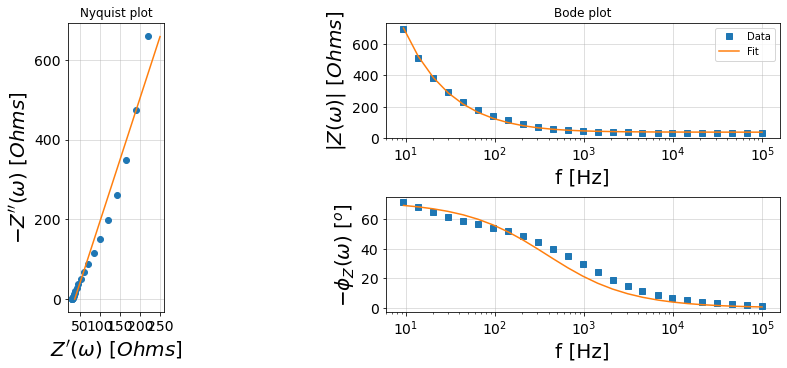


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.60e+01  (+/- 2.24e+00) [Ohm]
     R1 = 1.00e+07  (+/- 1.20e-09) [Ohm]
  CPE1_0 = 5.51e-05  (+/- 1.64e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 6.43e-03) []



Result of Cycle 1 at 589.0 mV vs. RHE:


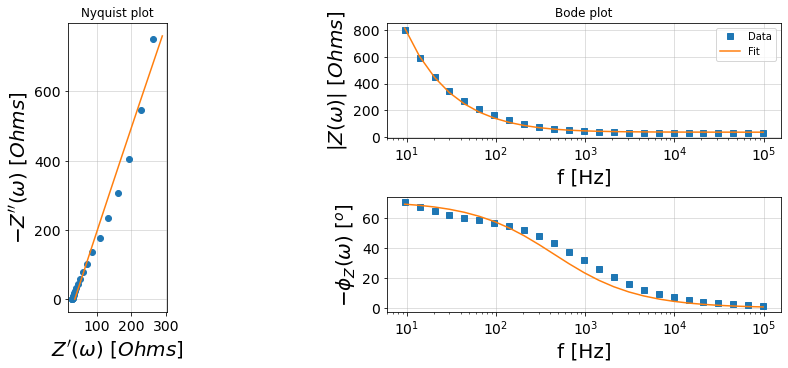


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.70e+01  (+/- 2.60e+00) [Ohm]
     R1 = 1.11e+05  (+/- 4.56e+05) [Ohm]
  CPE1_0 = 4.74e-05  (+/- 3.44e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 1.46e-02) []

Fitting error of parameter R1 at 409.1%


Result of Cycle 2 at 614.0 mV vs. RHE:


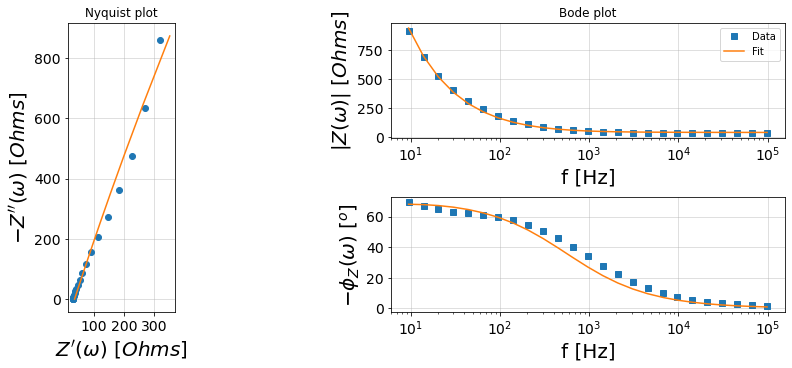


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.61e+01  (+/- 2.77e+00) [Ohm]
     R1 = 2.68e+04  (+/- 2.08e+04) [Ohm]
  CPE1_0 = 4.06e-05  (+/- 2.71e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 1.35e-02) []

Fitting error of parameter R1 at 77.7%


Result of Cycle 3 at 639.0 mV vs. RHE:


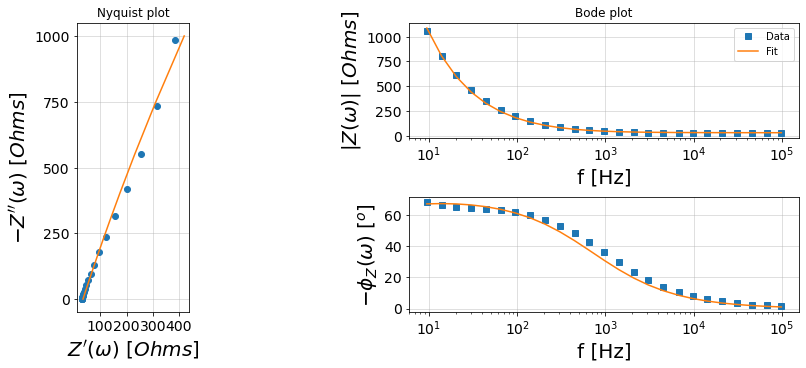


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.42e+01  (+/- 2.58e+00) [Ohm]
     R1 = 1.92e+04  (+/- 7.40e+03) [Ohm]
  CPE1_0 = 3.48e-05  (+/- 1.86e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 1.08e-02) []

Fitting error of parameter R1 at 38.5%


Result of Cycle 4 at 664.0 mV vs. RHE:


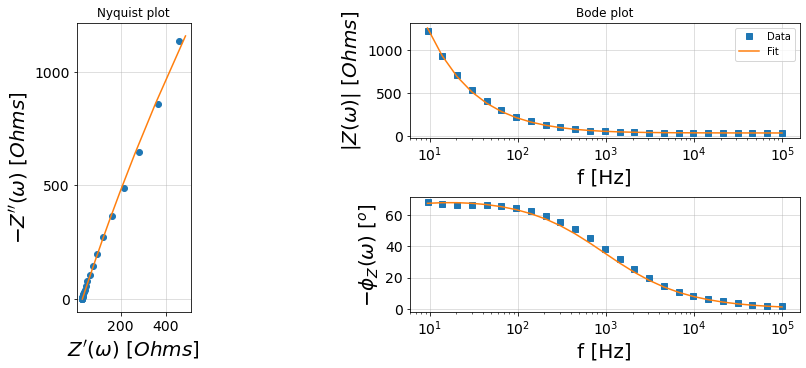


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.19e+01  (+/- 2.21e+00) [Ohm]
     R1 = 1.99e+04  (+/- 5.07e+03) [Ohm]
  CPE1_0 = 3.00e-05  (+/- 1.19e-06) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 7.99e-03) []

Fitting error of parameter R1 at 25.4%


Result of Cycle 5 at 689.0 mV vs. RHE:


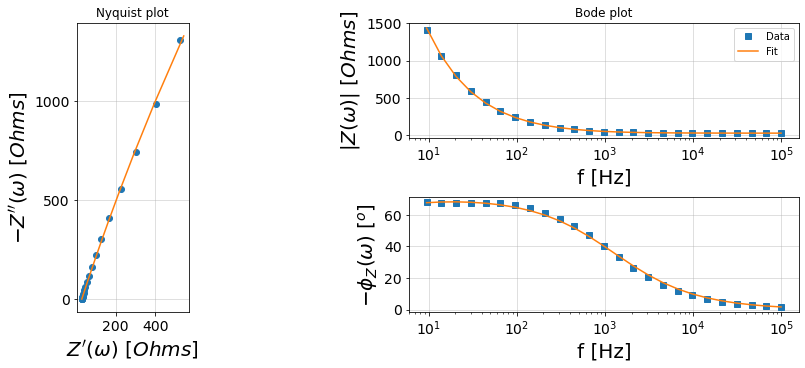


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.91e+01  (+/- 1.62e+00) [Ohm]
     R1 = 2.44e+04  (+/- 4.26e+03) [Ohm]
  CPE1_0 = 2.62e-05  (+/- 6.64e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 5.11e-03) []

Fitting error of parameter R1 at 17.4%


Result of Cycle 6 at 714.0 mV vs. RHE:


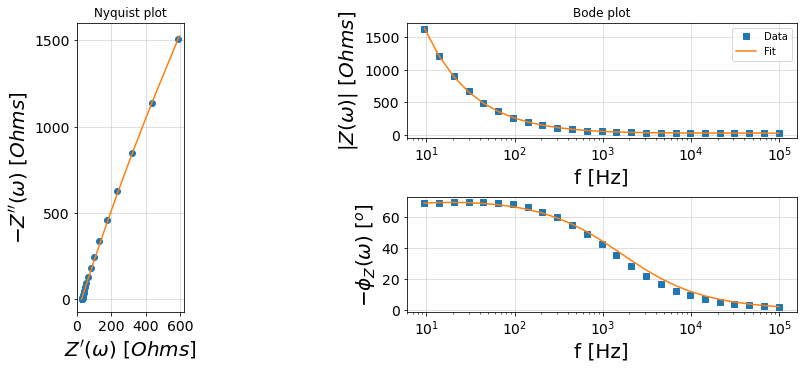


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.65e+01  (+/- 1.29e+00) [Ohm]
     R1 = 3.26e+04  (+/- 4.64e+03) [Ohm]
  CPE1_0 = 2.27e-05  (+/- 4.01e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.04e-01  (+/- 3.57e-03) []

Fitting error of parameter R1 at 14.2%


Result of Cycle 7 at 739.0 mV vs. RHE:


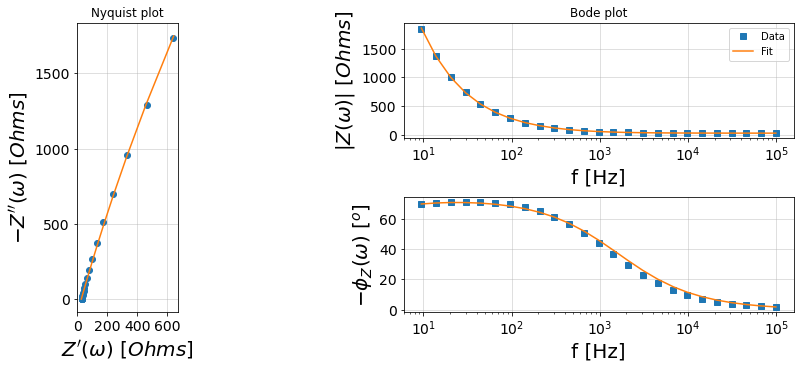


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.73e+01  (+/- 1.09e+00) [Ohm]
     R1 = 2.84e+04  (+/- 2.29e+03) [Ohm]
  CPE1_0 = 1.82e-05  (+/- 2.39e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.25e-01  (+/- 2.69e-03) []



Result of Cycle 8 at 764.0 mV vs. RHE:


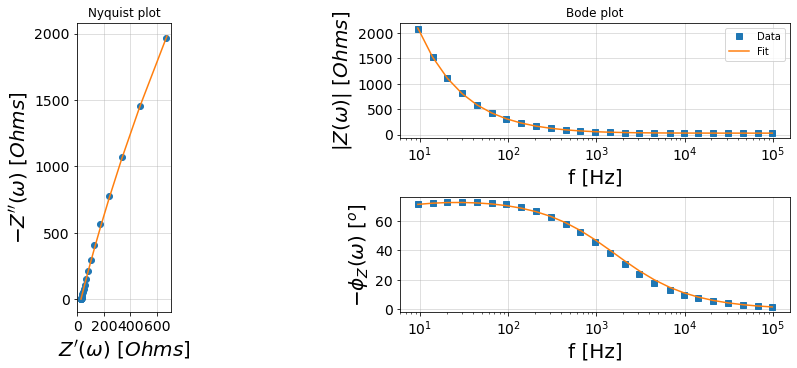


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.80e+01  (+/- 9.48e-01) [Ohm]
     R1 = 2.88e+04  (+/- 1.63e+03) [Ohm]
  CPE1_0 = 1.50e-05  (+/- 1.52e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.44e-01  (+/- 2.10e-03) []



Result of Cycle 9 at 789.0 mV vs. RHE:


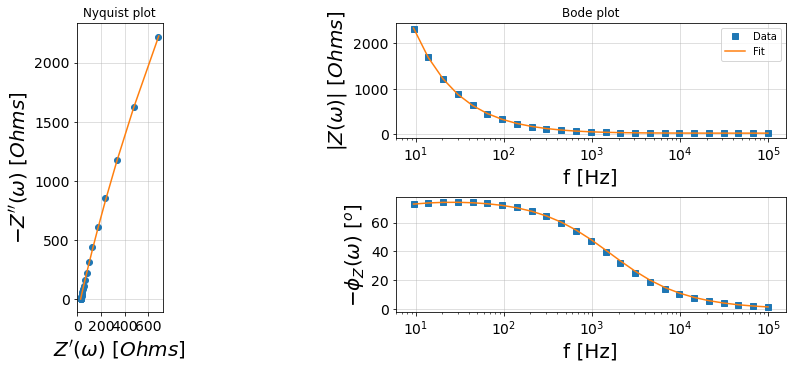


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.87e+01  (+/- 7.46e-01) [Ohm]
     R1 = 3.41e+04  (+/- 1.45e+03) [Ohm]
  CPE1_0 = 1.27e-05  (+/- 9.16e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.58e-01  (+/- 1.50e-03) []



Result of Cycle 10 at 814.0 mV vs. RHE:


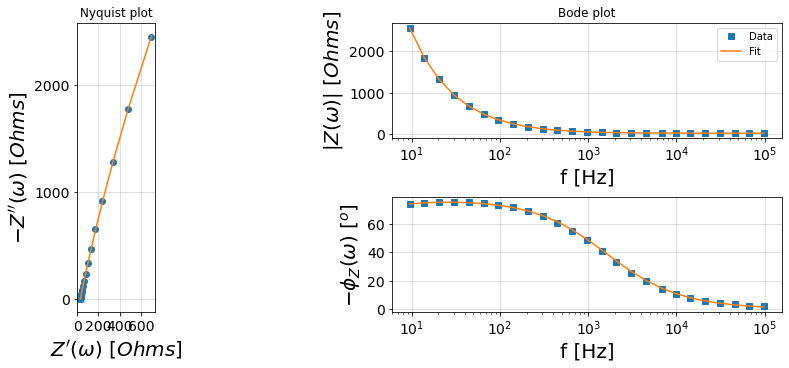


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.94e+01  (+/- 5.55e-01) [Ohm]
     R1 = 3.96e+04  (+/- 1.22e+03) [Ohm]
  CPE1_0 = 1.10e-05  (+/- 5.36e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.72e-01  (+/- 1.02e-03) []



Result of Cycle 11 at 839.0 mV vs. RHE:


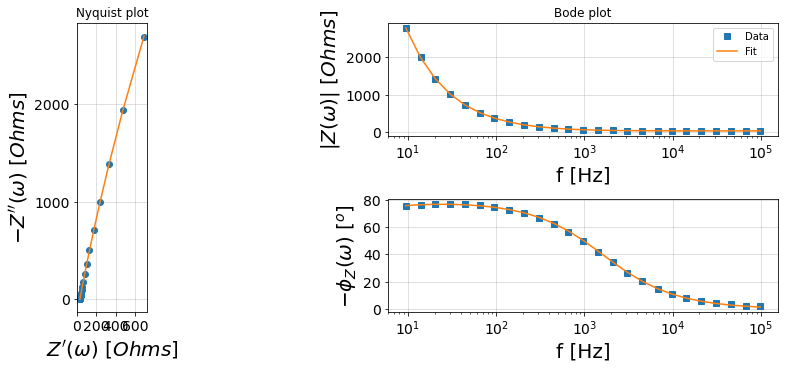


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.00e+01  (+/- 3.82e-01) [Ohm]
     R1 = 5.01e+04  (+/- 1.13e+03) [Ohm]
  CPE1_0 = 9.66e-06  (+/- 2.98e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.82e-01  (+/- 6.49e-04) []



Result of Cycle 12 at 864.0 mV vs. RHE:


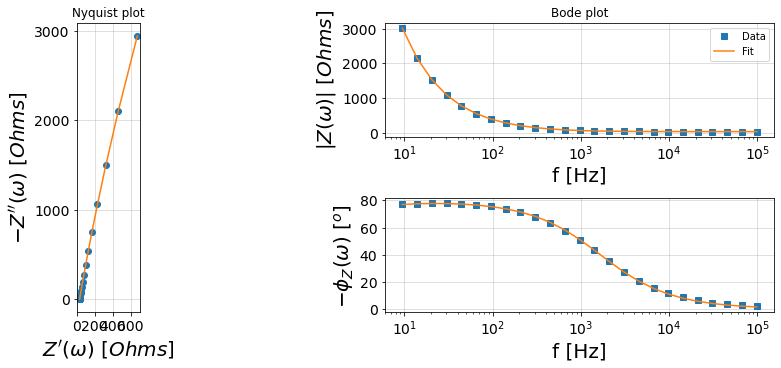


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.04e+01  (+/- 3.07e-01) [Ohm]
     R1 = 6.52e+04  (+/- 1.32e+03) [Ohm]
  CPE1_0 = 8.62e-06  (+/- 1.97e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.92e-01  (+/- 4.84e-04) []



Result of Cycle 13 at 889.0 mV vs. RHE:


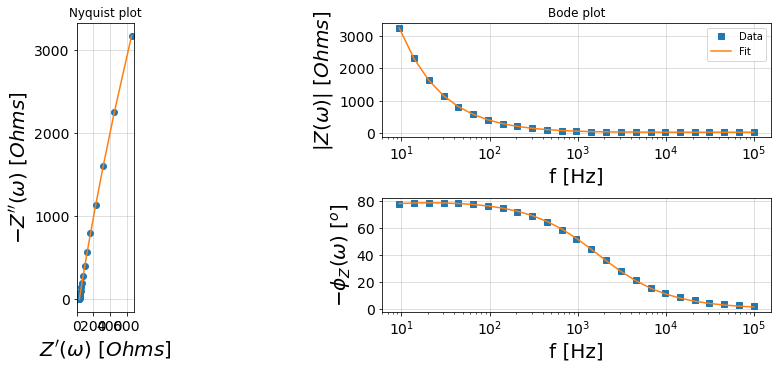


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.06e+01  (+/- 2.57e-01) [Ohm]
     R1 = 8.70e+04  (+/- 1.71e+03) [Ohm]
  CPE1_0 = 7.82e-06  (+/- 1.40e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.99e-01  (+/- 3.80e-04) []



Result of Cycle 14 at 914.0 mV vs. RHE:


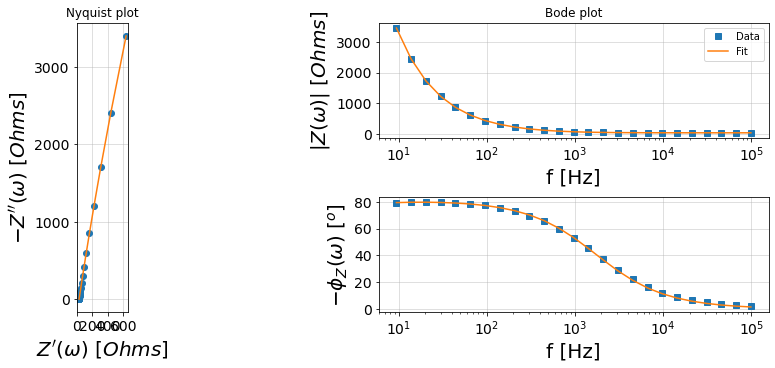


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.10e+01  (+/- 1.67e-01) [Ohm]
     R1 = 1.21e+05  (+/- 1.89e+03) [Ohm]
  CPE1_0 = 7.14e-06  (+/- 7.81e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.05e-01  (+/- 2.33e-04) []



Result of Cycle 15 at 939.0 mV vs. RHE:


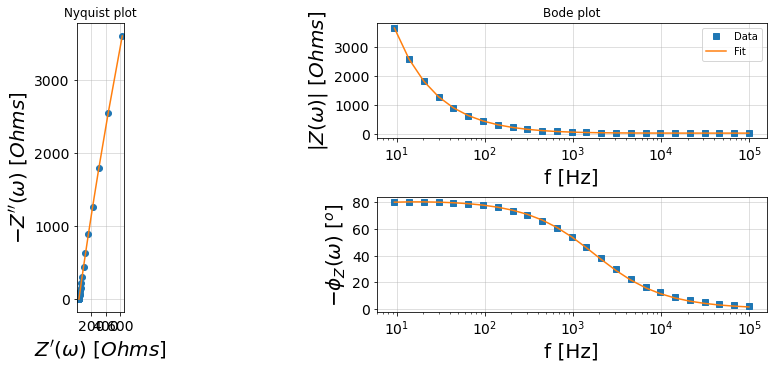


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.12e+01  (+/- 1.67e-01) [Ohm]
     R1 = 1.49e+05  (+/- 2.55e+03) [Ohm]
  CPE1_0 = 6.57e-06  (+/- 6.77e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.12e-01  (+/- 2.20e-04) []



Result of Cycle 16 at 964.0 mV vs. RHE:


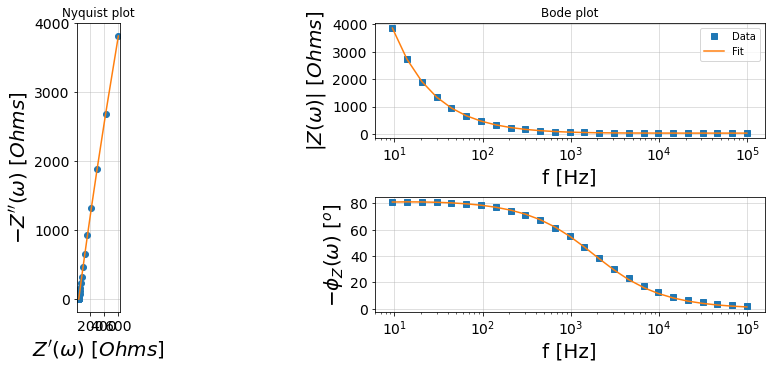


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.12e+01  (+/- 2.06e-01) [Ohm]
     R1 = 2.14e+05  (+/- 5.84e+03) [Ohm]
  CPE1_0 = 6.12e-06  (+/- 7.35e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.16e-01  (+/- 2.57e-04) []



Result of Cycle 17 at 989.0 mV vs. RHE:


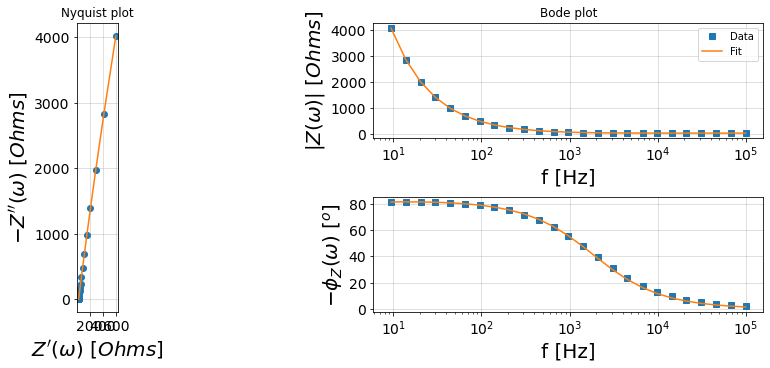


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.16e+01  (+/- 1.92e-01) [Ohm]
     R1 = 2.36e+05  (+/- 6.01e+03) [Ohm]
  CPE1_0 = 5.70e-06  (+/- 6.06e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.21e-01  (+/- 2.28e-04) []



Result of Cycle 18 at 1014.0 mV vs. RHE:


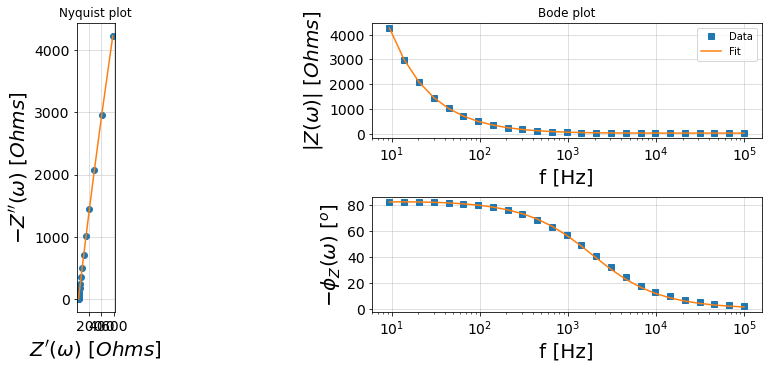


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.18e+01  (+/- 2.25e-01) [Ohm]
     R1 = 3.06e+05  (+/- 1.07e+04) [Ohm]
  CPE1_0 = 5.33e-06  (+/- 6.34e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.26e-01  (+/- 2.56e-04) []



Result of Cycle 19 at 1039.0 mV vs. RHE:


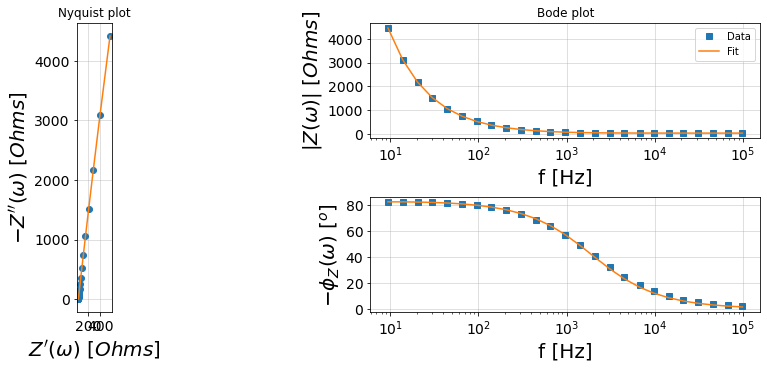


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.17e+01  (+/- 2.23e-01) [Ohm]
     R1 = 4.87e+05  (+/- 2.47e+04) [Ohm]
  CPE1_0 = 5.04e-06  (+/- 5.68e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.30e-01  (+/- 2.43e-04) []



Result of Cycle 20 at 1064.0 mV vs. RHE:


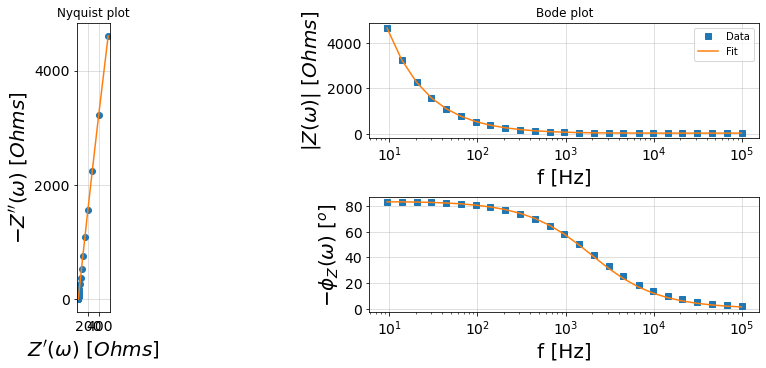


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.19e+01  (+/- 2.38e-01) [Ohm]
     R1 = 5.36e+05  (+/- 2.96e+04) [Ohm]
  CPE1_0 = 4.76e-06  (+/- 5.51e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.33e-01  (+/- 2.50e-04) []



Result of Cycle 21 at 1089.0 mV vs. RHE:


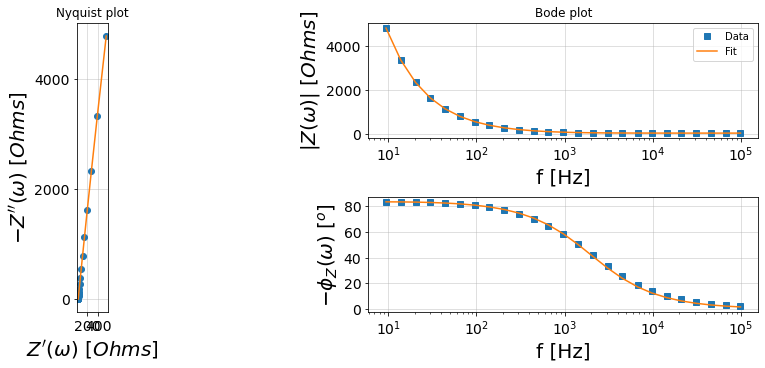


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.59e-01) [Ohm]
     R1 = 6.80e+05  (+/- 4.80e+04) [Ohm]
  CPE1_0 = 4.52e-06  (+/- 5.47e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.37e-01  (+/- 2.62e-04) []



Result of Cycle 22 at 1114.0 mV vs. RHE:


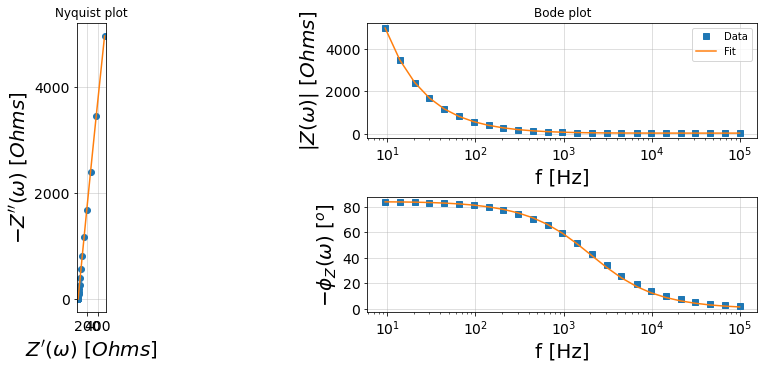


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.20e+01  (+/- 2.48e-01) [Ohm]
     R1 = 9.25e+05  (+/- 1.68e-07) [Ohm]
  CPE1_0 = 4.31e-06  (+/- 2.16e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.40e-01  (+/- 1.08e-04) []



Result of Cycle 23 at 1139.0 mV vs. RHE:


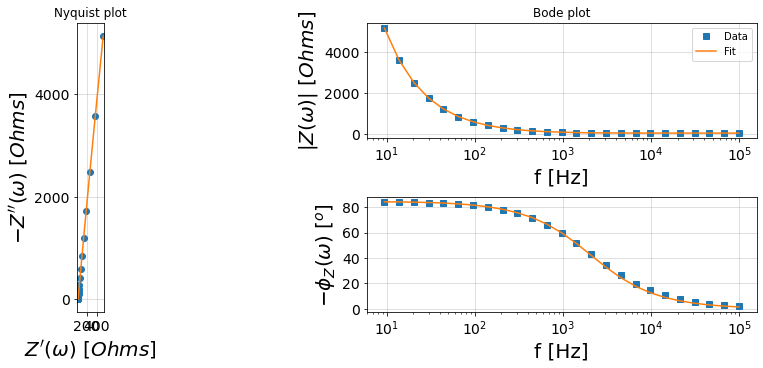


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.77e-01) [Ohm]
     R1 = 1.01e+06  (+/- 1.65e-07) [Ohm]
  CPE1_0 = 4.12e-06  (+/- 2.24e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.43e-01  (+/- 1.16e-04) []



Result of Cycle 24 at 1164.0 mV vs. RHE:


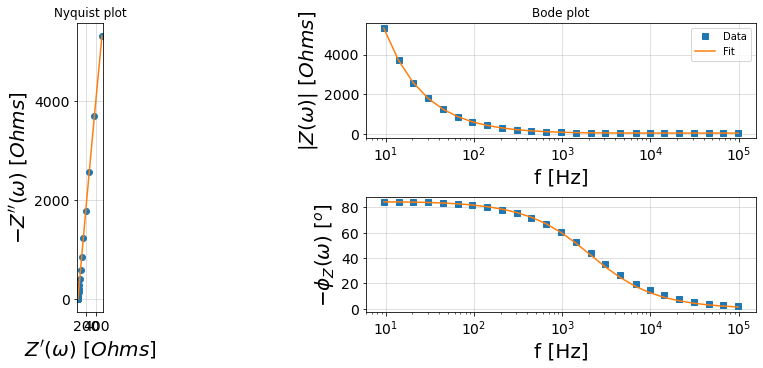


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.24e+01  (+/- 3.03e-01) [Ohm]
     R1 = 1.05e+06  (+/- 1.78e-07) [Ohm]
  CPE1_0 = 3.94e-06  (+/- 2.28e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.45e-01  (+/- 1.24e-04) []



Result of Cycle 25 at 1189.0 mV vs. RHE:


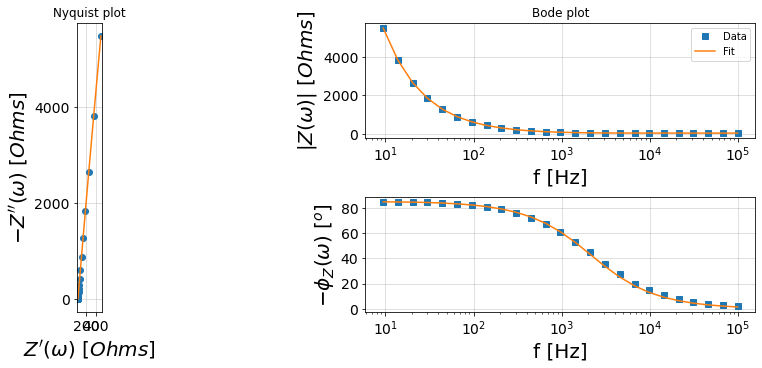


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.73e-01) [Ohm]
     R1 = 1.37e+06  (+/- 9.74e-08) [Ohm]
  CPE1_0 = 3.80e-06  (+/- 1.92e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.47e-01  (+/- 1.08e-04) []



Result of Cycle 26 at 1214.0 mV vs. RHE:


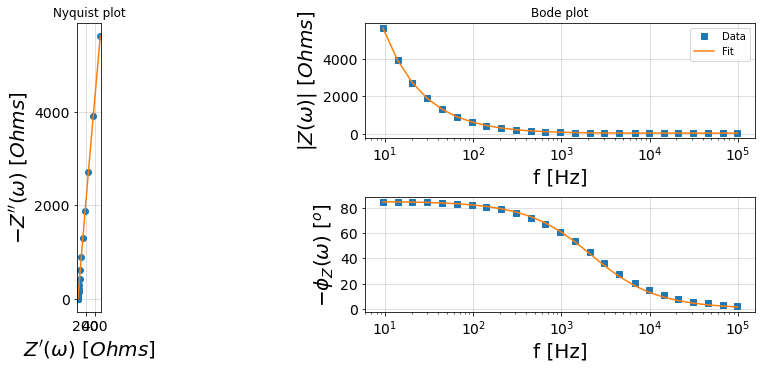


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.80e-01) [Ohm]
     R1 = 1.11e+06  (+/- 1.62e-07) [Ohm]
  CPE1_0 = 3.67e-06  (+/- 1.85e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.49e-01  (+/- 1.08e-04) []



Result of Cycle 27 at 1239.0 mV vs. RHE:


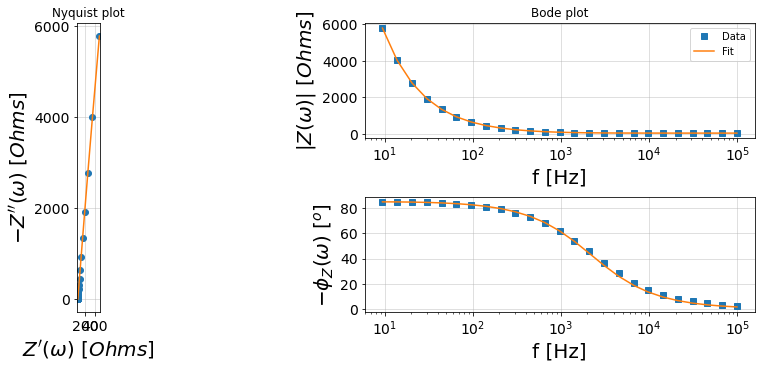


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.24e+01  (+/- 2.95e-01) [Ohm]
     R1 = 1.08e+06  (+/- 1.89e-07) [Ohm]
  CPE1_0 = 3.54e-06  (+/- 1.83e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.51e-01  (+/- 1.11e-04) []



Result of Cycle 28 at 1264.0 mV vs. RHE:


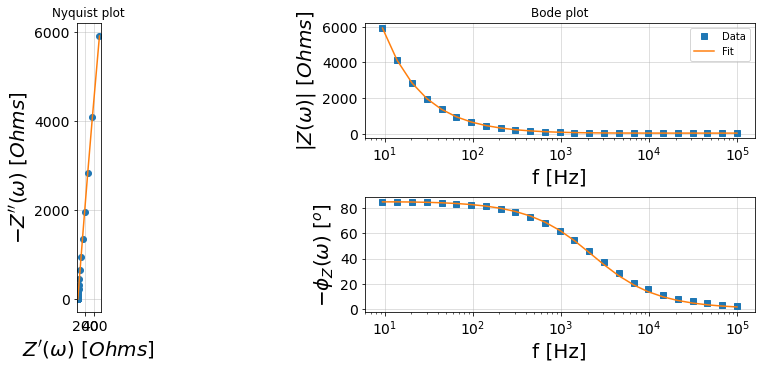


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.84e-01) [Ohm]
     R1 = 8.31e+05  (+/- 3.19e-07) [Ohm]
  CPE1_0 = 3.44e-06  (+/- 1.68e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.52e-01  (+/- 1.04e-04) []



Result of Cycle 29 at 1289.0 mV vs. RHE:


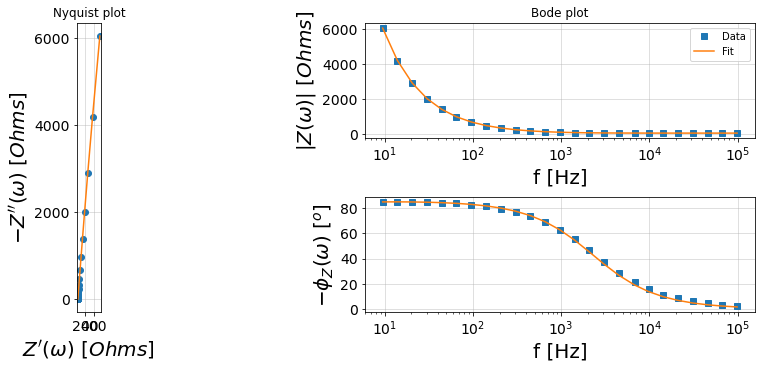


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.24e+01  (+/- 3.02e-01) [Ohm]
     R1 = 6.27e+05  (+/- 3.00e+04) [Ohm]
  CPE1_0 = 3.36e-06  (+/- 3.76e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.53e-01  (+/- 2.44e-04) []



Result of Cycle 30 at 1314.0 mV vs. RHE:


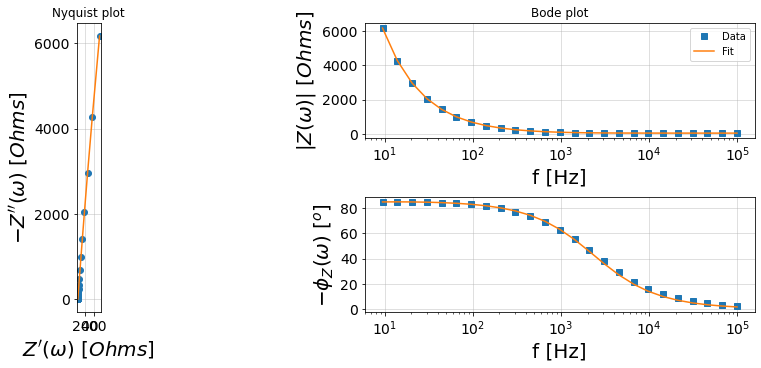


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.80e-01) [Ohm]
     R1 = 5.96e+05  (+/- 2.42e+04) [Ohm]
  CPE1_0 = 3.27e-06  (+/- 3.33e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.54e-01  (+/- 2.21e-04) []



Result of Cycle 31 at 1339.0 mV vs. RHE:


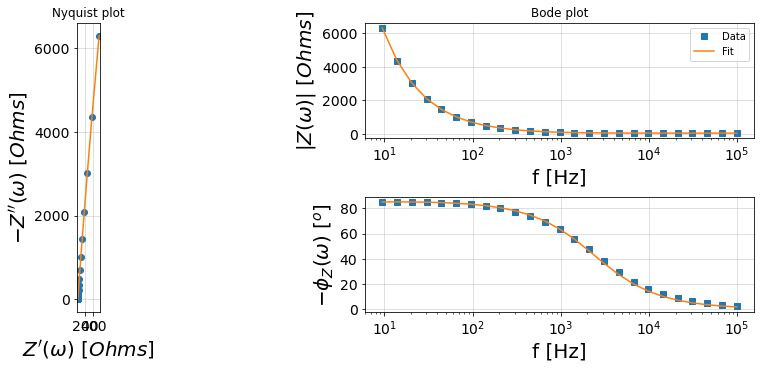


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.23e+01  (+/- 2.91e-01) [Ohm]
     R1 = 6.09e+05  (+/- 2.52e+04) [Ohm]
  CPE1_0 = 3.19e-06  (+/- 3.31e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.55e-01  (+/- 2.26e-04) []



Result of Cycle 32 at 1364.0 mV vs. RHE:


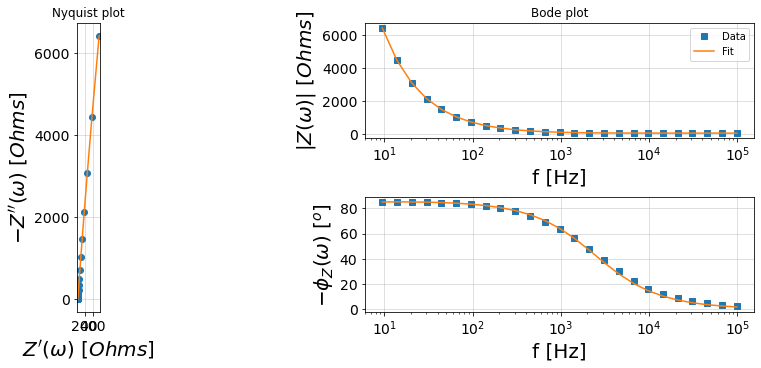


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.19e+01  (+/- 3.38e-01) [Ohm]
     R1 = 5.92e+05  (+/- 2.68e+04) [Ohm]
  CPE1_0 = 3.14e-06  (+/- 3.71e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.56e-01  (+/- 2.58e-04) []



Result of Cycle 33 at 1389.0 mV vs. RHE:


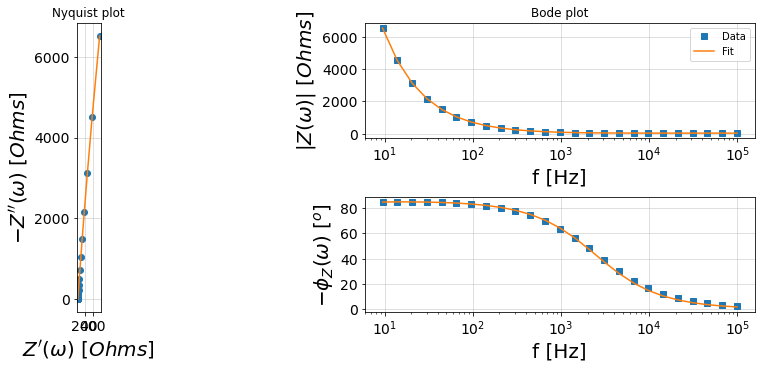


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.20e+01  (+/- 3.35e-01) [Ohm]
     R1 = 4.77e+05  (+/- 1.66e+04) [Ohm]
  CPE1_0 = 3.08e-06  (+/- 3.53e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.56e-01  (+/- 2.51e-04) []



Result of Cycle 34 at 1414.0 mV vs. RHE:


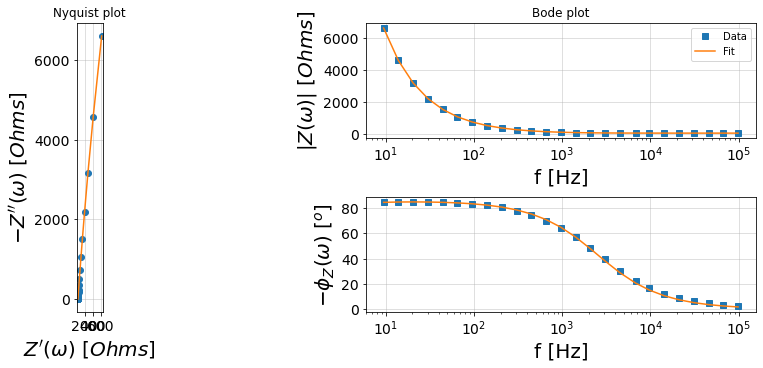


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.18e+01  (+/- 3.64e-01) [Ohm]
     R1 = 3.16e+05  (+/- 7.70e+03) [Ohm]
  CPE1_0 = 3.03e-06  (+/- 3.74e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.56e-01  (+/- 2.69e-04) []



Result of Cycle 35 at 1439.0 mV vs. RHE:


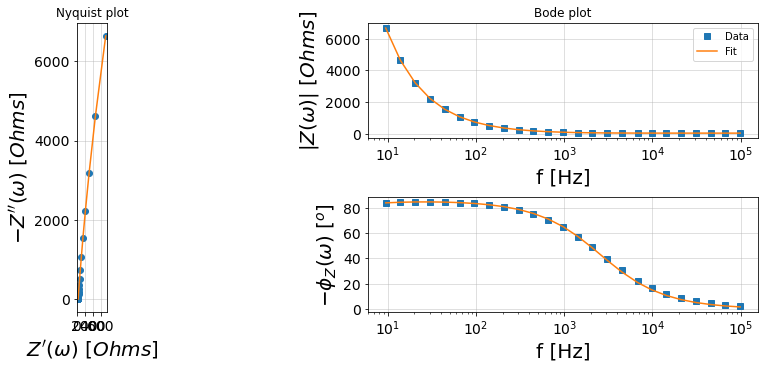


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.17e+01  (+/- 3.20e-01) [Ohm]
     R1 = 1.98e+05  (+/- 2.62e+03) [Ohm]
  CPE1_0 = 3.02e-06  (+/- 3.25e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.55e-01  (+/- 2.35e-04) []



Result of Cycle 36 at 1464.0 mV vs. RHE:


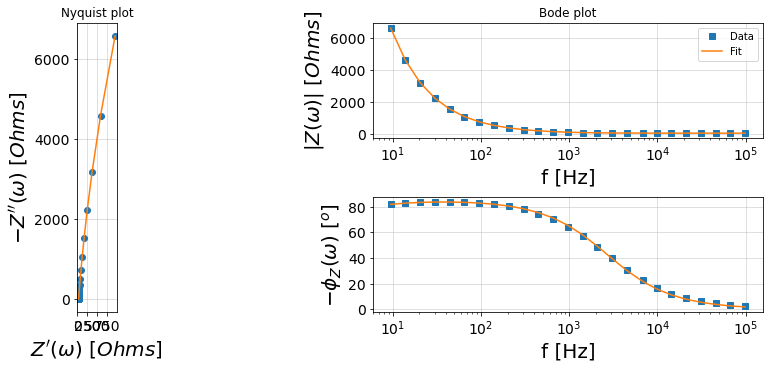


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.10e+01  (+/- 4.11e-01) [Ohm]
     R1 = 1.08e+05  (+/- 1.00e+03) [Ohm]
  CPE1_0 = 3.07e-06  (+/- 4.25e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.51e-01  (+/- 3.02e-04) []



Result of Cycle 37 at 1489.0 mV vs. RHE:


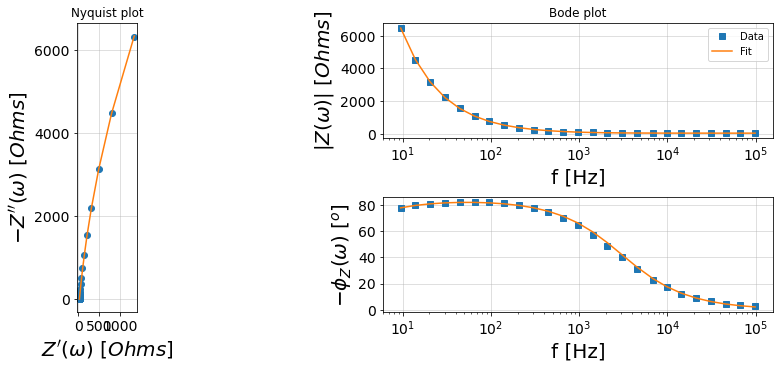


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.89e+01  (+/- 1.07e+00) [Ohm]
     R1 = 5.69e+04  (+/- 7.58e+02) [Ohm]
  CPE1_0 = 3.24e-06  (+/- 1.20e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.41e-01  (+/- 8.00e-04) []



Result of Cycle 38 at 1514.0 mV vs. RHE:


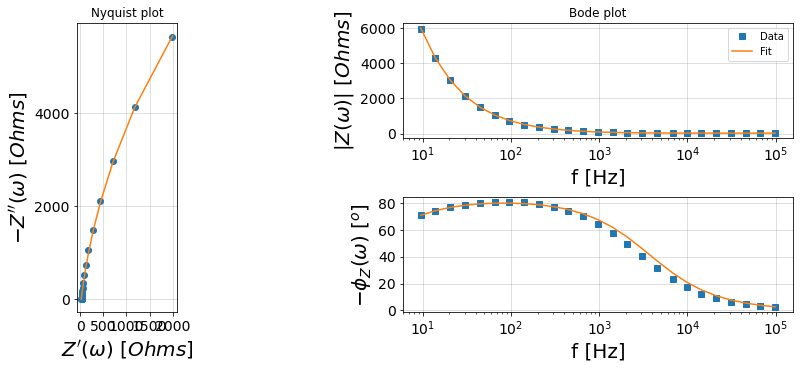


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.54e+01  (+/- 2.17e+00) [Ohm]
     R1 = 2.81e+04  (+/- 4.20e+02) [Ohm]
  CPE1_0 = 3.64e-06  (+/- 2.91e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.24e-01  (+/- 1.71e-03) []



Result of Cycle 39 at 1539.0 mV vs. RHE:


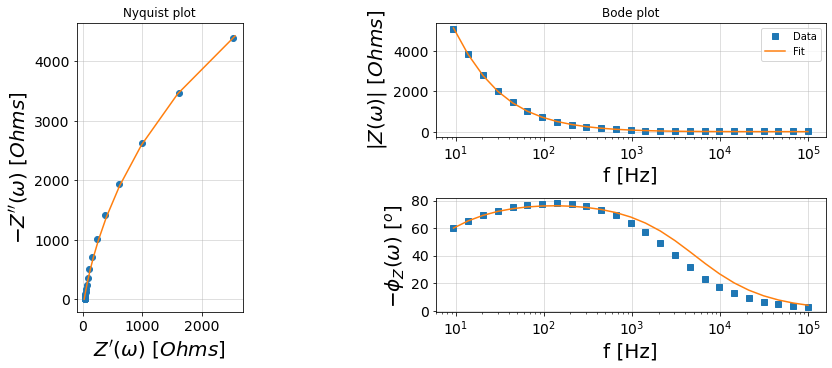


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.09e+01  (+/- 3.51e+00) [Ohm]
     R1 = 1.45e+04  (+/- 2.33e+02) [Ohm]
  CPE1_0 = 4.47e-06  (+/- 6.65e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.94e-01  (+/- 3.12e-03) []

Fitting error of parameter R0 at 16.8%


Result of Cycle 40 at 1564.0 mV vs. RHE:


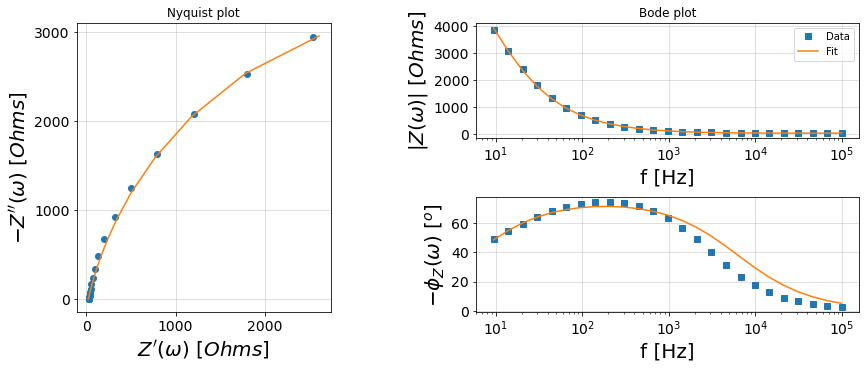


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.00e+01  (+/- 4.69e+00) [Ohm]
     R1 = 8.11e+03  (+/- 1.45e+02) [Ohm]
  CPE1_0 = 5.99e-06  (+/- 1.49e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.55e-01  (+/- 5.05e-03) []

Fitting error of parameter R0 at 23.4%




<IPython.core.display.Javascript object>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist
import pandas as pd
from IPython.core.debugger import set_trace

%notify -m "The fitting has been started!"
for i in range(cycle_start, cycle_end+1):
    print("Result of Cycle \033[1m" + str(i) + "\033[0m at " + str(potentials_RHE[i]) + " mV vs. RHE:")
    Z_i = Z[i][cutoff_start:cutoff_end]
    frequency_i = frequencies[i][cutoff_start:cutoff_end]
    model_circuit.fit(frequency_i, Z_i, bounds=model_circuit_bounds)
    
    sp.plot_model_fit_overview(frequency_i, Z_i, model_circuit)
    plt.show()
    print(model_circuit)
    
    errorlist = [0]
    for j in range(len(model_circuit.parameters_)):
        relerror = model_circuit.conf_[j]/model_circuit.parameters_[j]
        errorlist.append(relerror)
        if relerror > 0.1:
            print("Fitting error of parameter " + model_circuit.get_param_names()[0][j] + " at " + str(round(100*relerror, 1)) + "%")
    results.append(model_circuit.parameters_.tolist() + model_circuit.conf_.tolist() + errorlist[1:])
    print("\n")
%notify -m "The fitting has been completed!"

## Wrap data into dataframe and save dataframe as Excel file and HTML report

In [9]:
names, units = model_circuit.get_param_names()
df = pd.DataFrame(data=results, columns=[names + ["Error of " + x for x in names] + ["Rel. Error of " + x for x in names]])

In [10]:
print(df)

           R0            R1    CPE1_0    CPE1_1 Error of R0   Error of R1  \
0   30.000000  1.000000e+03  0.000010  1.000000         NaN           NaN   
1   36.035205  1.000000e+07  0.000055  0.800000    2.239594  1.199840e-09   
2   36.993209  1.114083e+05  0.000047  0.800000    2.596224  4.558254e+05   
3   36.075911  2.681110e+04  0.000041  0.800000    2.770464  2.083022e+04   
4   34.228902  1.923220e+04  0.000035  0.800000    2.576609  7.396750e+03   
5   31.892933  1.993107e+04  0.000030  0.800000    2.210793  5.067502e+03   
6   29.070182  2.442809e+04  0.000026  0.800000    1.617190  4.255875e+03   
7   26.494479  3.261092e+04  0.000023  0.803767    1.290141  4.641619e+03   
8   27.290321  2.838492e+04  0.000018  0.825035    1.089657  2.291719e+03   
9   28.006399  2.879603e+04  0.000015  0.843676    0.947928  1.626012e+03   
10  28.721836  3.408427e+04  0.000013  0.858428    0.746111  1.454540e+03   
11  29.403162  3.964270e+04  0.000011  0.871835    0.554889  1.215587e+03   

In [11]:
#Add voltage steps to the dataframe as first two columns
df.insert(loc = 0, column = "V vs. Ag/AgCl (mV)", value = ["(initial guess)"] + potentials_Ag[cycle_start:cycle_end+1])
df.insert(loc = 1, column = "V vs. RHE (mV)", value = ["(initial guess)"] + potentials_RHE[cycle_start:cycle_end+1])

Optional: Calculate real capacitance based on CPE and R values using  C = ( CPE-T * R )(1/CPE-P) / R

In [12]:
if model == "1RCPE":
    df.insert(loc = len(df.columns), column = "C_1 (calculated)", value = [pow((df.loc[i]["CPE1_0"]*df.loc[i]["R1"]), 1/df.loc[i]["CPE1_1"])/df.loc[i]["R1"] for i in range(df.shape[0])])

In [13]:
# Create file directory for the analysis
import os
if not os.path.exists(filename):
    os.makedirs(filename)

In [14]:
# Output to excel
savefile = model + "-Analysis_" + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + " - " + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + "mV within " + '{:.1e}'.format(lowest_freq) + " - " + '{:.1e}'.format(highest_freq) + "Hz of " + filename
df.to_excel("./" + filename + "//" + savefile + ".xlsx")

In [15]:
# Save notebook output as HTML
os.system('jupyter nbconvert --to html --output "./' + filename + '//' + savefile + '" "SPEIS automated analysis.ipynb"')

0

## Post-analysis and embedded data treatment

In [16]:
%matplotlib notebook
# Create plot for calculated capacitance
fig, ax = plt.subplots()

x = df[1:]["V vs. Ag/AgCl (mV)"].values
y = df[1:]["C_1 (calculated)"].values
sum_error = df[1:]["Rel. Error of CPE1_0"].values.flatten() + df[1:]["Rel. Error of R1"].values.flatten() + df[1:]["Rel. Error of CPE1_1"].values.flatten() / 3
y_error = np.multiply(df[1:]["C_1 (calculated)"].values.flatten(), sum_error)

plt.scatter(x, y)
ax.errorbar(x, y, yerr = y_error, linestyle="None")
plt.ylabel("Capacitance (F)")
plt.xlabel("V vs RHE")
plt.ylim(min(y)*0.9, max(y)*1.1)
fig.set_size_inches(13,8)
plt.title("C1 vs. Potential (V vs. RHE)")
for i in range(df.index[0], df.index[-1]):
    ax.annotate(i+1, (x[i], y[i]))
plt.ion()
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
print("Which cycle do you want to fit again?")
inspec_cycle_no = int(input())+1

model_circuit = CustomCircuit(model_circuit.circuit, initial_guess=model_circuit.initial_guess)
model_circuit.parameters_ = df.iloc[inspec_cycle_no][2:2+len(model_circuit.initial_guess)].values
model_circuit.conf_ = df.iloc[inspec_cycle_no][len(model_circuit.initial_guess)+2:2+2*len(model_circuit.initial_guess)].values
model_circuit.plot(f_data=frequencies[inspec_cycle_no-1][cutoff_start:cutoff_end], Z_data=Z[inspec_cycle_no-1][cutoff_start:cutoff_end], kind="bode")

print(model_circuit)

Which cycle do you want to fit again?
